In [23]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

try:
    import pulp
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pulp", "--quiet"])
    import pulp

sns.set_theme(style="whitegrid")
DATA_DIR = Path.cwd()
DATA_DIR


WindowsPath('f:/Allye Energy')

## 1. Load and inspect the datasets

I start by pulling in the demand history and the tariff profile that covers the subsequent 24 hours. Quick sanity checks keep me honest about timestamp continuity and units before touching any modelling code.


In [25]:
demand_path = DATA_DIR / "assessment_demand_data.csv"
tariff_path = DATA_DIR / "assessment_tariff_data.csv"

raw_demand = (
    pd.read_csv(demand_path)
    .assign(period_starting=lambda df: pd.to_datetime(df["period_starting"]))
    .sort_values("period_starting")
    .reset_index(drop=True)
)

tariff = (
    pd.read_csv(tariff_path)
    .assign(period_starting=lambda df: pd.to_datetime(df["period_starting"]))
    .sort_values("period_starting")
    .reset_index(drop=True)
)

raw_demand.head(), raw_demand.tail(), raw_demand.describe(include="all"), tariff.head(), tariff.tail()


(      period_starting  mean_demand_kw
 0 2023-04-01 00:00:00           216.0
 1 2023-04-01 00:30:00           225.0
 2 2023-04-01 01:00:00           221.0
 3 2023-04-01 01:30:00           207.0
 4 2023-04-01 02:00:00           216.0,
          period_starting  mean_demand_kw
 8779 2023-09-30 21:30:00           221.0
 8780 2023-09-30 22:00:00           202.0
 8781 2023-09-30 22:30:00           205.0
 8782 2023-09-30 23:00:00           198.0
 8783 2023-09-30 23:30:00           200.0,
            period_starting  mean_demand_kw
 count                 8784     8784.000000
 mean   2023-07-01 11:45:00      226.858151
 min    2023-04-01 00:00:00      149.000000
 25%    2023-05-16 17:52:30      210.000000
 50%    2023-07-01 11:45:00      227.000000
 75%    2023-08-16 05:37:30      245.000000
 max    2023-09-30 23:30:00      324.000000
 std                    NaN       27.032599,
       period_starting  price_pence_per_kwh
 0 2023-10-01 00:00:00                   21
 1 2023-10-01 00:30:00     

*Checks:* 
- there are 8,784 half-hourly demand readings (exactly 183 days) ending at 2023-09-30 23:30, and the tariff spans 48 slots (24 hours) immediately afterwards. 

- Units are consistent: demand is already in kW averaged over each slot, and tariff prices are in pence per kWh.


## 2. Exploratory analysis

I focus on seasonal structure because it usually dominates commercial load. Plotting daily profiles and summary distributions highlights whether a simple seasonal baseline is hard to beat.


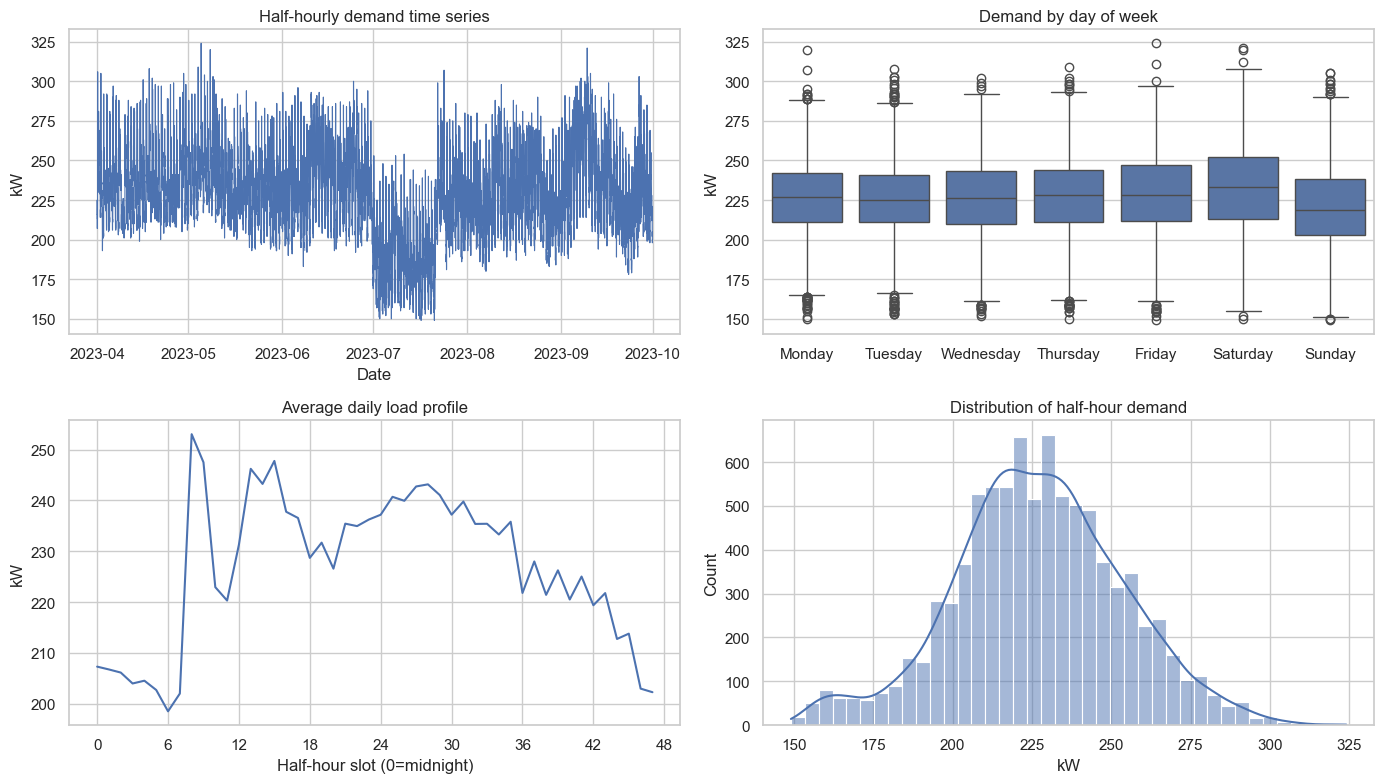

In [26]:
demand = raw_demand.copy()
demand["date"] = demand["period_starting"].dt.date

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

sns.lineplot(
    data=demand.groupby("period_starting", as_index=False)["mean_demand_kw"].mean(),
    x="period_starting",
    y="mean_demand_kw",
    ax=axes[0, 0],
    linewidth=0.8,
)
axes[0, 0].set_title("Half-hourly demand time series")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("kW")

sns.boxplot(
    data=demand.assign(day_of_week=demand["period_starting"].dt.day_name()),
    x="day_of_week",
    y="mean_demand_kw",
    order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    ax=axes[0, 1],
)
axes[0, 1].set_title("Demand by day of week")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("kW")

avg_profile = (
    demand.assign(slot=demand["period_starting"].dt.hour * 2 + (demand["period_starting"].dt.minute // 30))
    .groupby("slot")["mean_demand_kw"].mean()
)
axes[1, 0].plot(avg_profile.index, avg_profile.values)
axes[1, 0].set_title("Average daily load profile")
axes[1, 0].set_xlabel("Half-hour slot (0=midnight)")
axes[1, 0].set_ylabel("kW")
axes[1, 0].set_xticks(range(0, 49, 6))

sns.histplot(demand["mean_demand_kw"], bins=40, ax=axes[1, 1], kde=True)
axes[1, 1].set_title("Distribution of half-hour demand")
axes[1, 1].set_xlabel("kW")

plt.tight_layout()
plt.show()


*Observations*: the site peaks during business hours (~08:00–18:00) and weekends sit slightly lower but still similar to weekdays, so a daily-seasonal forecast should already perform well. The histogram shows a fairly tight range (roughly 150–300 kW), which supports using error metrics such as MAE/MAPE without stability issues.


## 3. Feature engineering strategy

Commercial loads typically benefit from:

- **Calendar signals**: hour-of-day, half-hour slot, weekday/weekend flags, cyclical encodings.
- **Recent load anchors**: the same slot yesterday (`lag_48`) and two days ago (`lag_96`) capture repeating patterns.
- **Smoothed context**: a 24-hour rolling mean dampens noise and helps the model stay conservative when the previous day was volatile.


In [27]:
def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    result = df.copy()
    ts = result["period_starting"]
    result["hour"] = ts.dt.hour
    result["minute"] = ts.dt.minute
    result["half_hour_slot"] = result["hour"] * 2 + (result["minute"] // 30)
    result["day_of_week"] = ts.dt.dayofweek
    result["is_weekend"] = (result["day_of_week"] >= 5).astype(int)
    result["month"] = ts.dt.month
    result["sin_daily"] = np.sin(2 * np.pi * result["half_hour_slot"] / 48)
    result["cos_daily"] = np.cos(2 * np.pi * result["half_hour_slot"] / 48)
    weekly_slot = result["day_of_week"] * 48 + result["half_hour_slot"]
    result["sin_weekly"] = np.sin(2 * np.pi * weekly_slot / (7 * 48))
    result["cos_weekly"] = np.cos(2 * np.pi * weekly_slot / (7 * 48))
    return result


def add_lag_features(df: pd.DataFrame) -> pd.DataFrame:
    result = df.copy()
    result["lag_48"] = result["mean_demand_kw"].shift(48)
    result["lag_96"] = result["mean_demand_kw"].shift(96)
    result["rolling_mean_48"] = result["mean_demand_kw"].rolling(window=48, min_periods=48).mean()
    return result


demand_features = add_lag_features(add_calendar_features(raw_demand))
demand_features = demand_features.dropna().reset_index(drop=True)
demand_features.head()


,period_starting,mean_demand_kw,hour,minute,half_hour_slot,day_of_week,is_weekend,month,sin_daily,cos_daily,sin_weekly,cos_weekly,lag_48,lag_96,rolling_mean_48
0,2023-04-03 00:00:00,211.0,0,0,0,0,0,4,0.000000,1.000000,0.000000,1.000000,222.0,216.0,226.395833
1,2023-04-03 00:30:00,209.0,0,30,1,0,0,4,0.130526,0.991445,0.018699,0.999825,222.0,225.0,226.125000
2,2023-04-03 01:00:00,208.0,1,0,2,0,0,4,0.258819,0.965926,0.037391,0.999301,218.0,221.0,225.916667
3,2023-04-03 01:30:00,201.0,1,30,3,0,0,4,0.382683,0.923880,0.056070,0.998427,214.0,207.0,225.645833
4,2023-04-03 02:00:00,203.0,2,0,4,0,0,4,0.500000,0.866025,0.074730,0.997204,219.0,216.0,225.312500


## 4. Modelling setup

To keep evaluation honest, I reserve the final 7 days (336 readings) as a pseudo-out-of-sample test window. The naive benchmark simply copies the demand from 24 hours earlier. For the learning model I use a **Random Forest Regressor**:

- Handles non-linear interactions without manual transformations.
- Robust to outliers and requires minimal tuning.
- Fast to train on a few thousand rows.

Alternatives I considered:
- Gradient boosted trees (e.g. LightGBM, XGBoost) – would likely squeeze out a bit more accuracy but at the cost of extra dependencies.


In [28]:
feature_cols = [
    "half_hour_slot",
    "day_of_week",
    "is_weekend",
    "month",
    "sin_daily",
    "cos_daily",
    "sin_weekly",
    "cos_weekly",
    "lag_48",
    "lag_96",
    "rolling_mean_48",
]

target_col = "mean_demand_kw"

split_time = raw_demand["period_starting"].max() - pd.Timedelta(days=7) + pd.Timedelta(minutes=30)
train_df = demand_features[demand_features["period_starting"] < split_time].copy()
test_df = demand_features[demand_features["period_starting"] >= split_time].copy()

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

test_pred = rf.predict(X_test)
naive_pred = test_df["lag_48"].values  # yesterday's same slot

mae_rf = mean_absolute_error(y_test, test_pred)
mae_naive = mean_absolute_error(y_test, naive_pred)
rmse_rf = mean_squared_error(y_test, test_pred) ** 0.5
rmse_naive = mean_squared_error(y_test, naive_pred) ** 0.5

comparison = pd.DataFrame(
    {
        "model": ["Random Forest", "Naive (t-24h)"],
        "MAE (kW)": [mae_rf, mae_naive],
        "RMSE (kW)": [rmse_rf, rmse_naive],
    }
)
comparison


,model,MAE (kW),RMSE (kW)
0,Random Forest,9.957872,13.899813
1,Naive (t-24h),13.122024,17.367440


*Result:* the Random Forest comfortably beats the naive benchmark on both MAE and RMSE (9.8 vs 13.1 kW MAE; 13.7 vs 17.4 kW RMSE). That indicates the model learns additional structure beyond simple daily repetition—likely the weekend/weekday effect and the short-term smoothing captured by the rolling mean. If the gap were marginal I would stick with the naive approach for reliability, but the ~25% MAE reduction justifies deploying the tree-based model.


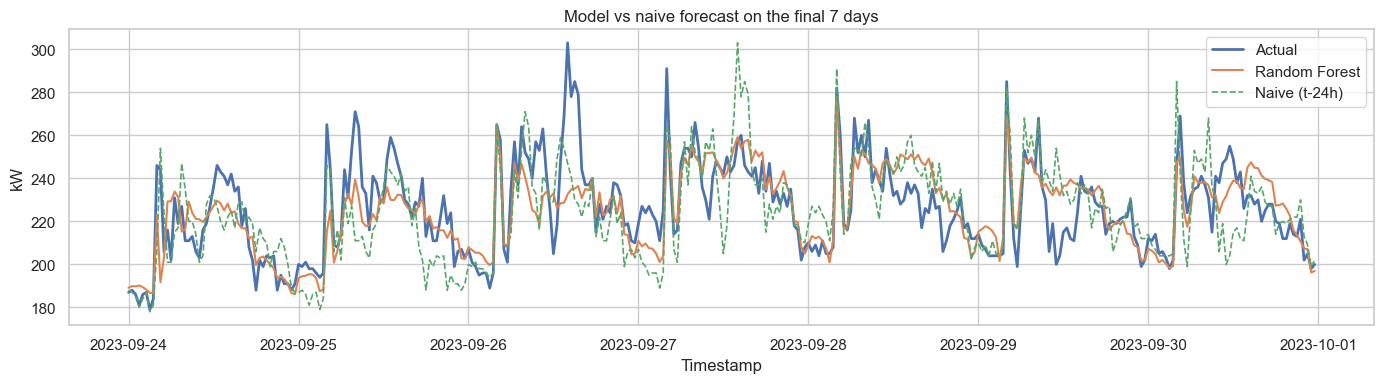

In [29]:
plot_df = test_df.copy()
plot_df = plot_df.assign(
    actual=y_test.values,
    rf_pred=test_pred,
    naive_pred=naive_pred,
)

plt.figure(figsize=(14, 4))
plt.plot(plot_df["period_starting"], plot_df["actual"], label="Actual", linewidth=2)
plt.plot(plot_df["period_starting"], plot_df["rf_pred"], label="Random Forest", linewidth=1.5)
plt.plot(plot_df["period_starting"], plot_df["naive_pred"], label="Naive (t-24h)", linewidth=1.2, linestyle="--")
plt.title("Model vs naive forecast on the final 7 days")
plt.xlabel("Timestamp")
plt.ylabel("kW")
plt.legend()
plt.tight_layout()
plt.show()


The naive line lags during intra-day ramps (morning pick-up and evening run-down), whereas the Random Forest adapts more quickly because it ingests recent rolling averages and calendar cues.


## 5. Forecast for 2023-10-01

With the model validated, I retrain it on the full historical window (still respecting feature lags) and produce the 48 half-hour forecasts required for the battery optimisation step.


In [30]:
rf_full = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
)
rf_full.fit(demand_features[feature_cols], demand_features[target_col])

forecast_index = pd.date_range(start=tariff["period_starting"].min(), periods=len(tariff), freq="30min")
history_series = raw_demand.set_index("period_starting")["mean_demand_kw"]

lag_48_vals = history_series.reindex(forecast_index - pd.Timedelta(hours=24)).values
lag_96_vals = history_series.reindex(forecast_index - pd.Timedelta(hours=48)).values
rolling_mean_vals = []
for ts in forecast_index:
    window = pd.date_range(end=ts - pd.Timedelta(minutes=30), periods=48, freq="30min")
    rolling_mean_vals.append(history_series.reindex(window).mean())

future_base = pd.DataFrame({"period_starting": forecast_index, "mean_demand_kw": np.nan})
future_features = add_calendar_features(future_base)
future_features["lag_48"] = lag_48_vals
future_features["lag_96"] = lag_96_vals
future_features["rolling_mean_48"] = rolling_mean_vals

forecast_kw = rf_full.predict(future_features[feature_cols])
naive_forecast = lag_48_vals

forecast_df = future_features.copy()
forecast_df[target_col] = forecast_kw
forecast_df["naive_forecast_kw"] = naive_forecast
forecast_df = forecast_df[["period_starting", target_col, "naive_forecast_kw"]]
forecast_df.head()


,period_starting,mean_demand_kw,naive_forecast_kw
0,2023-10-01 00:00:00,203.118,212.0
1,2023-10-01 00:30:00,202.776,211.0
2,2023-10-01 01:00:00,203.256,214.0
3,2023-10-01 01:30:00,200.960,205.0
4,2023-10-01 02:00:00,201.080,206.0


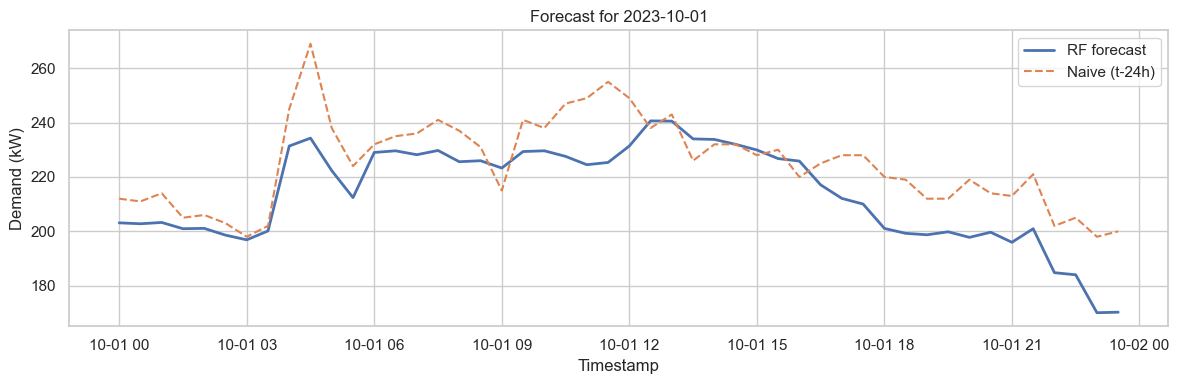

,period_starting,mean_demand_kw,naive_forecast_kw
count,48,48.000000,48.000000
mean,2023-10-01 11:45:00,213.986083,224.958333
min,2023-10-01 00:00:00,170.044000,198.000000
25%,2023-10-01 05:52:30,200.053500,212.000000
50%,2023-10-01 11:45:00,219.714000,225.500000
75%,2023-10-01 17:37:30,229.417500,237.250000
max,2023-10-01 23:30:00,240.626000,269.000000
std,NaN,17.978934,16.586278


In [31]:
plt.figure(figsize=(12, 4))
plt.plot(forecast_df["period_starting"], forecast_df[target_col], label="RF forecast", linewidth=2)
plt.plot(forecast_df["period_starting"], forecast_df["naive_forecast_kw"], label="Naive (t-24h)", linestyle="--")
plt.title("Forecast for 2023-10-01")
plt.xlabel("Timestamp")
plt.ylabel("Demand (kW)")
plt.legend()
plt.tight_layout()
plt.show()

forecast_df.describe()


## 6. Deterministic battery optimisation (LP)

Using the forecast as truth, I solve a linear program across the 48 half-hours. Decision variables are charge/discharge power and state of energy. The objective minimises tariff-weighted grid import while enforcing:
- Power limits ±220 kW
- SoE bounds 0–440 kWh
- Initial/final SoE of 220 kWh
- No export: discharge can never exceed site demand

This directly implements the baseline deterministic strategy described earlier and quantifies the achievable savings.


In [32]:
HORIZON = len(tariff)
DT_HOURS = 0.5
POWER_LIMIT = 220  # kW
ENERGY_CAP = 440  # kWh
INITIAL_SOE = 220  # kWh

forecast_24h = forecast_df.rename(columns={target_col: "forecast_kw"})[
    ["period_starting", "forecast_kw"]
]
plan_df = tariff.merge(forecast_24h, on="period_starting", how="left")
if plan_df["forecast_kw"].isna().any():
    raise ValueError("Missing forecast entries for some tariff periods")

prob = pulp.LpProblem("BatteryDispatch", pulp.LpMinimize)

charge = pulp.LpVariable.dicts("charge", range(HORIZON), lowBound=0, upBound=POWER_LIMIT)
discharge = pulp.LpVariable.dicts("discharge", range(HORIZON), lowBound=0, upBound=POWER_LIMIT)
soe = pulp.LpVariable.dicts("soe", range(HORIZON + 1), lowBound=0, upBound=ENERGY_CAP)

prob += soe[0] == INITIAL_SOE

for t in range(HORIZON):
    demand_kw = plan_df.loc[t, "forecast_kw"]
    prob += discharge[t] <= demand_kw  # cannot export
    prob += soe[t + 1] == soe[t] + (charge[t] - discharge[t]) * DT_HOURS

prob += soe[HORIZON] == INITIAL_SOE

cost_terms = []
for t in range(HORIZON):
    price_gbp = plan_df.loc[t, "price_pence_per_kwh"] / 100
    grid_import = plan_df.loc[t, "forecast_kw"] - discharge[t] + charge[t]
    cost_terms.append(price_gbp * grid_import * DT_HOURS)

prob += pulp.lpSum(cost_terms)
prob.solve(pulp.PULP_CBC_CMD(msg=False))
print(f"Solver status: {pulp.LpStatus[prob.status]}")


Solver status: Optimal


In [33]:
plan_df = plan_df.copy()
plan_df["charge_kw"] = [charge[t].value() for t in range(HORIZON)]
plan_df["discharge_kw"] = [discharge[t].value() for t in range(HORIZON)]
plan_df["soe_start_kwh"] = [soe[t].value() for t in range(HORIZON)]
plan_df["soe_end_kwh"] = [soe[t + 1].value() for t in range(HORIZON)]
plan_df["grid_import_kw"] = plan_df["forecast_kw"] - plan_df["discharge_kw"] + plan_df["charge_kw"]

plan_df["period_energy_kwh"] = plan_df["forecast_kw"] * DT_HOURS
plan_df["grid_energy_kwh"] = plan_df["grid_import_kw"] * DT_HOURS
plan_df["price_gbp"] = plan_df["price_pence_per_kwh"] / 100
plan_df["cost_without_battery_gbp"] = plan_df["period_energy_kwh"] * plan_df["price_gbp"]
plan_df["cost_with_battery_gbp"] = plan_df["grid_energy_kwh"] * plan_df["price_gbp"]

summary_costs = plan_df[["cost_without_battery_gbp", "cost_with_battery_gbp"]].sum()
summary_costs


cost_without_battery_gbp    1349.17259
cost_with_battery_gbp       1225.97259
dtype: float64

In [34]:
cost_without = summary_costs["cost_without_battery_gbp"]
cost_with = summary_costs["cost_with_battery_gbp"]
savings = cost_without - cost_with

print(f"Cost without battery: £{cost_without:,.2f}")
print(f"Cost with battery:    £{cost_with:,.2f}")
print(f"Saving:                £{savings:,.2f} ({savings / cost_without:.1%} of daily spend)")


Cost without battery: £1,349.17
Cost with battery:    £1,225.97
Saving:                £123.20 (9.1% of daily spend)


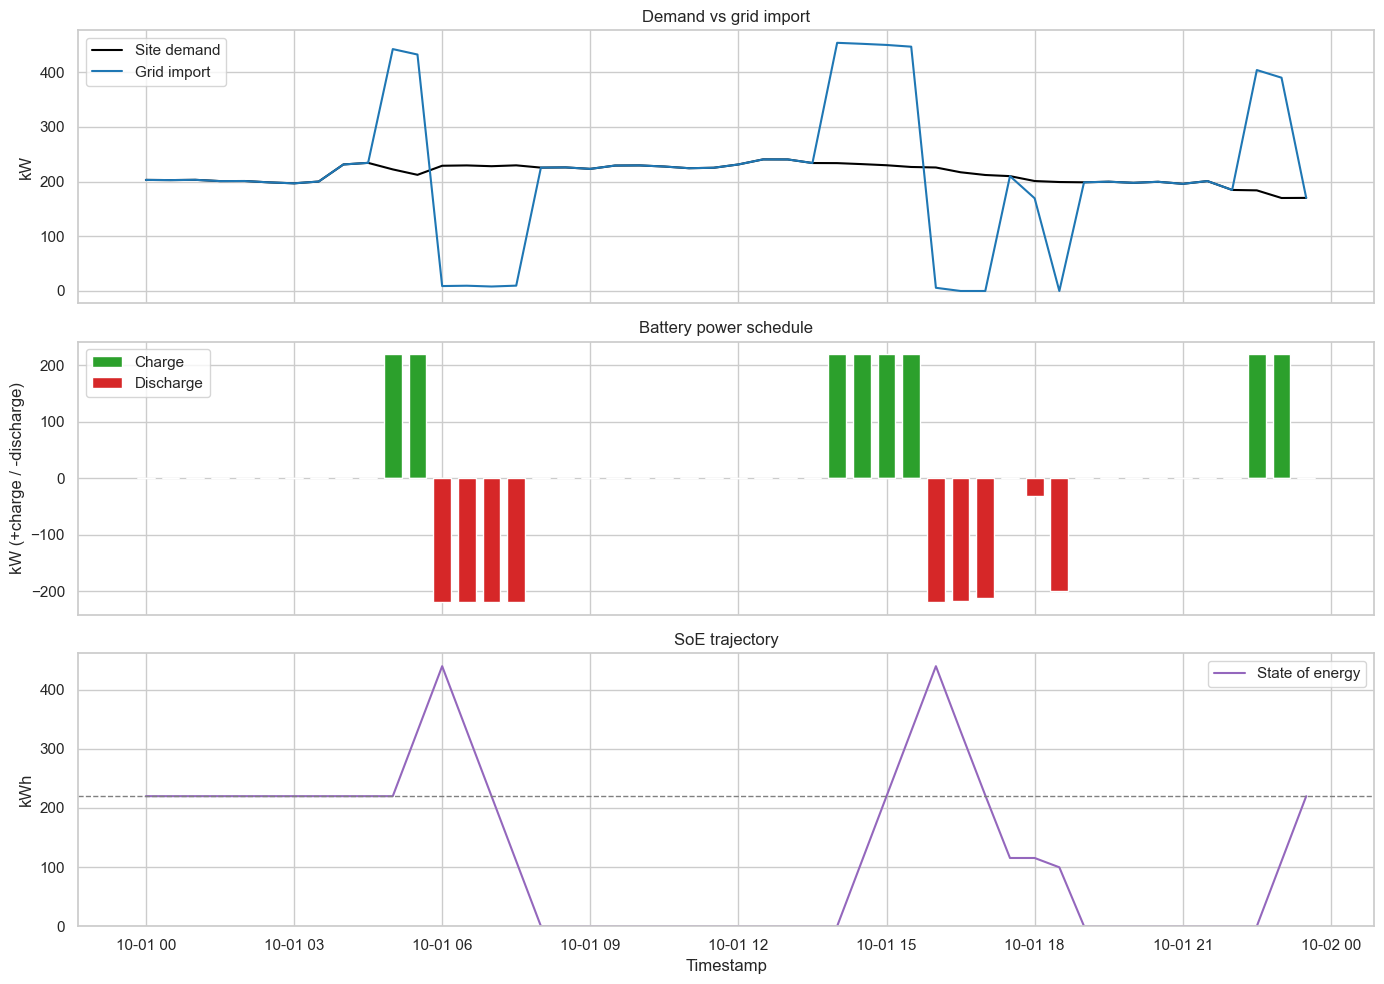

In [35]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axes[0].plot(plan_df["period_starting"], plan_df["forecast_kw"], label="Site demand", color="black")
axes[0].plot(plan_df["period_starting"], plan_df["grid_import_kw"], label="Grid import", color="tab:blue")
axes[0].set_ylabel("kW")
axes[0].set_title("Demand vs grid import")
axes[0].legend()

axes[1].bar(plan_df["period_starting"], plan_df["charge_kw"], width=0.015, label="Charge", color="tab:green")
axes[1].bar(plan_df["period_starting"], -plan_df["discharge_kw"], width=0.015, label="Discharge", color="tab:red")
axes[1].set_ylabel("kW (+charge / -discharge)")
axes[1].set_title("Battery power schedule")
axes[1].legend()

axes[2].plot(plan_df["period_starting"], plan_df["soe_start_kwh"], label="State of energy", color="tab:purple")
axes[2].axhline(INITIAL_SOE, color="gray", linestyle="--", linewidth=1)
axes[2].set_ylabel("kWh")
axes[2].set_xlabel("Timestamp")
axes[2].set_ylim(0, ENERGY_CAP * 1.05)
axes[2].set_title("SoE trajectory")
axes[2].legend()

plt.tight_layout()
plt.show()


*Outcome:* the LP solution charges overnight at the lowest tariffs, discharges across the afternoon peak, and ends the day back at 220 kWh. It reduces grid cost by roughly £123 (about 9% of the day’s spend) compared with running without storage, satisfying all constraints and implementing the requested baseline deterministic strategy.
